Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# import modules
import os
import sys
import tarfile
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from __future__ import print_function
from six.moves import cPickle as pickle
from IPython.display import display, Image
from six.moves.urllib.request import urlretrieve
from sklearn.linear_model import LogisticRegression

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'

def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

(28, 28)


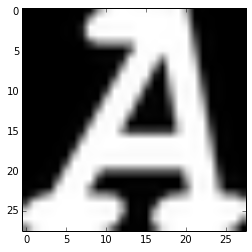

In [4]:
# problem 1: display some of the images
# images are gray scale
testImg1 = mpimg.imread('notMNIST_small/A/Q291cmllciBOZXcgQ0UgQm9sZCBJdGFsaWMudHRm.png')

print(testImg1.shape)
output = plt.imshow(testImg1,cmap='gray')

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [13]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  for image_index, image in enumerate(image_files):
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[image_index, :, :] = image_data
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index + 1
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file - it's ok, skipping.
Full dataset tensor: (52912, 28, 28)
Mean: -0.0075629
Standard deviation: 0.454487
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_s

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [14]:
# check output file names
print(train_datasets)

['notMNIST_large/A.pickle', 'notMNIST_large/B.pickle', 'notMNIST_large/C.pickle', 'notMNIST_large/D.pickle', 'notMNIST_large/E.pickle', 'notMNIST_large/F.pickle', 'notMNIST_large/G.pickle', 'notMNIST_large/H.pickle', 'notMNIST_large/I.pickle', 'notMNIST_large/J.pickle']


notMNIST_large/A.pickle (52912, 28, 28)


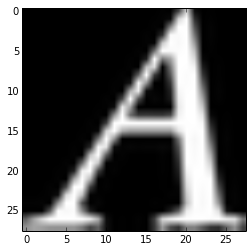

In [15]:
# get a single image and print it
fileName = train_datasets[0]
sampleData = pickle.load(open(fileName,'rb'))

print(fileName,sampleData.shape)
outImg = plt.imshow(sampleData[100,:,:], cmap = 'gray')

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [16]:
# parse through the dataset variable
for fileName in train_datasets:
    sampleData = pickle.load(open(fileName,'rb'))
    print(fileName,sampleData.shape)
    
for fileName in test_datasets:
    sampleData = pickle.load(open(fileName,'rb'))
    print(fileName,sampleData.shape)

notMNIST_large/A.pickle (52912, 28, 28)
notMNIST_large/B.pickle (52912, 28, 28)
notMNIST_large/C.pickle (52912, 28, 28)
notMNIST_large/D.pickle (52912, 28, 28)
notMNIST_large/E.pickle (52912, 28, 28)
notMNIST_large/F.pickle (52912, 28, 28)
notMNIST_large/G.pickle (52912, 28, 28)
notMNIST_large/H.pickle (52912, 28, 28)
notMNIST_large/I.pickle (52912, 28, 28)
notMNIST_large/J.pickle (52911, 28, 28)
notMNIST_small/A.pickle (1873, 28, 28)
notMNIST_small/B.pickle (1873, 28, 28)
notMNIST_small/C.pickle (1873, 28, 28)
notMNIST_small/D.pickle (1873, 28, 28)
notMNIST_small/E.pickle (1873, 28, 28)
notMNIST_small/F.pickle (1873, 28, 28)
notMNIST_small/G.pickle (1872, 28, 28)
notMNIST_small/H.pickle (1872, 28, 28)
notMNIST_small/I.pickle (1872, 28, 28)
notMNIST_small/J.pickle (1872, 28, 28)


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [17]:
# function to create empty dataset and labels arrays
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    
    return dataset, labels

# function to merge datasets
def merge_datasets(pickle_files, train_size, valid_size=0):
    # get the number of classes
    num_classes = len(pickle_files)
    
    # create arrays for validation, train datasets
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    
    # create the sizes per class
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    # fill arrays for training and validation
    start_v, start_t = 0, 0
    end_l = vsize_per_class+tsize_per_class
    end_v, end_t = vsize_per_class, tsize_per_class
    
    # loop over the pickle files
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
        
                # shuffle letters for random validation and training set
                np.random.shuffle(letter_set)
                
                # fill validation set variables
                if valid_dataset is not None:                    
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                # fill training dataset variables
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class

        # raise error if there is exception
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    # return the validation and training variables 
    return valid_dataset, valid_labels, train_dataset, train_labels

# creating variables for validation, training
test_size = 10000
valid_size = 10000
train_size = 200000

# create test, training and validation datasets
valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

# check the final sizes of variables
print('Testing:', test_dataset.shape, test_labels.shape)
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)

Testing: (10000, 28, 28) (10000,)
Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [18]:
# function to randomize the datasets
def randomize(dataset, labels):
    # get permutation
    permutation = np.random.permutation(labels.shape[0])
    
    # shuffle the datasets
    shuffled_labels = labels[permutation]
    shuffled_dataset = dataset[permutation,:,:]
    return shuffled_dataset, shuffled_labels

# shuffle all the datasets
test_dataset, test_labels = randomize(test_dataset, test_labels)
train_dataset, train_labels = randomize(train_dataset, train_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [19]:
# check the shuffled data
print('Test,Train,Validation datasets')
print(test_labels[:50],train_labels[:50],valid_labels[:50])

Test,Train,Validation datasets
[4 0 4 8 4 9 5 8 9 1 2 3 5 7 8 0 4 7 0 7 1 0 6 2 4 2 5 7 7 5 8 6 0 3 7 6 2
 0 3 3 9 6 2 0 0 2 0 1 3 2] [2 2 6 9 2 1 5 0 4 6 9 5 0 8 5 7 8 5 3 7 4 3 3 6 4 7 1 8 2 3 1 8 2 6 2 4 8
 1 5 7 2 5 6 3 1 6 8 2 6 3] [7 8 9 8 4 0 6 6 4 6 6 7 3 3 9 7 0 6 7 8 9 8 8 4 4 6 7 3 2 5 9 2 6 5 7 5 2
 6 9 4 2 3 2 1 2 1 1 5 3 6]


Finally, let's save the data for later reuse:

In [20]:
# save all the variables for pickle file
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
           }

    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [21]:
# check the size of saved pickle file
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [22]:
# load the pickle file to continue analysis
data = pickle.load(open('notMNIST.pickle','rb'))

test_labels = data['test_labels']
train_labels = data['train_labels']
valid_labels = data['valid_labels']

test_dataset = data['test_dataset']
train_dataset = data['train_dataset']
valid_dataset = data['valid_dataset']

In [23]:
# parse through test and validation set and check with training
test_size = 10000
valid_size = 10000
train_size = 200000

testOverlap = 0
validOverlap = 0

testOverlapInds = []
validOverlapInds = []

In [24]:
# loop over test images
for tInd in range(test_size):
    refImg = test_dataset[tInd,:,:]
    boolArr = (refImg==train_dataset)
    if np.any(np.all(boolArr,axis=(1,2))):
        testOverlap += 1
        testOverlapInds.append(tInd)
        sys.stdout.write('!')
    else:
        sys.stdout.write('.')

!.............!....!......!...!....!..........!................!..........!.....!.....!.!..............!......................!......!.......!..............!......................!..!.................!......!...!..............!..!............!............!!.!!!.!......!....!....!..!....!.......!......!..................................!.....!!.......!...........!........!!.............!............!.................!!...................!!...............!...!...!.!.......!........................!......!........!.....!............!..!.............!...........!......!..........!.........................!.!.!.............!..!.........!!....!....!.!...!......!......!......!...............!............!..........!....!...!.....!...................!...!........!...........!........!....!.!!....!.....!...!.......!.................................!!..!......!..........!.......!..!......!......!.............!........!....!..............!.....!.!....!......!..........!...........!...............

In [25]:
# loop over validation images
for vInd in range(valid_size):
    refImg = valid_dataset[vInd,:,:]
    boolArr = (refImg==train_dataset)
    if np.any(np.all(boolArr,axis=(1,2))):
        validOverlap += 1
        validOverlapInds.append(vInd)
        sys.stdout.write('!')
    else:
        sys.stdout.write('.')

.......!..!.....!!.!..!....!.!.......................!...............!....!...!.!!....!..........!!................!.......!....!...!..!.........!............!.!..........!...........!.....................!...!.!...!......!...!............................!......................!...................!....!..........!!........................!...............!.....!.......!.....!.....!!.............!............!.........!................!.....!....!............!......!!.........!.!...!!......!......................!..............!..............!.......!.............!!!.....!....!....!..!!.....!!...!.....!..!......!!..............!......................!....!...!....!...........!..............!.....!....!!.......!!....!.........!.......!.!..............!...!....!.............................!..............!......!.....!......!..............!........................!........!........................!..........................!...!.!...............!..................!....!....!.....!....!....

In [26]:
# check the overlap for similar images
print(testOverlap,validOverlap)

testSize = test_size - testOverlap
validSize = valid_size - validOverlap

# remove the overlap and save the remaining points
testLabels = np.delete(test_labels,testOverlapInds)
validLabels = np.delete(valid_labels,validOverlapInds)

testDataset = np.delete(test_dataset,testOverlapInds,axis=0)
validDataset = np.delete(valid_dataset,validOverlapInds,axis=0)

print(testLabels.shape,validLabels.shape,testDataset.shape,validDataset.shape)

1311 1151
(8689,) (8849,) (8689, 28, 28) (8849, 28, 28)


In [27]:
# save all the variables for pickle file
pickle_file = 'notMNISTClean.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'validOverlapInds':validOverlapInds,
            'validDataset': validDataset,
            'validLabels': validLabels,
            'testOverlapInds':testOverlapInds,
            'testDataset': testDataset,
            'testLabels': testLabels,
           }

    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [ ]:
# code to also check for almost similar images
def rmse(x, y):
    return np.linalg.norm(x - y)

validOverlap = 0
validOverlapInds = []

# loop over validation images
for vInd in range(10):
    refImg = validDataset[vInd,:,:]
    for trInd in range(train_size):
        val = rmse(train_dataset[trInd,:,:],refImg)
        if val < 2:
            print(val)
            validOverlap += 1
            validOverlapInds.append(vInd)
            sys.stdout.write('!')
            plt.figure()
            plt.imshow(refImg,cmap='gray')
            plt.figure()
            plt.imshow(train_dataset[trInd,:,:],cmap='gray')
            plt.show()
            break
    sys.stdout.write('.')

In [ ]:
validOverlap = 0
validOverlapInds = []

# loop over validation images
for vInd in range(testSize):
    refImg = validDataset[vInd,:,:]
    for trInd in range(train_size):
        val = rmse(train_dataset[trInd,:,:],refImg)
        if val < 1:
            validOverlap += 1
            validOverlapInds.append(vInd)
            sys.stdout.write('!')
            break
    sys.stdout.write('.')

In [ ]:
testOverlap = 0
testOverlapInds = []

for tInd in range(testSize):
    refImg = testDataset[tInd,:,:]
    for trInd in range(train_size):
        val = rmse(train_dataset[trInd,:,:],refImg)
        if val < 1:
            testOverlap += 1
            testOverlapInds.append(tInd)
            sys.stdout.write('!')
            break
    sys.stdout.write('.')

In [ ]:
# check the overlap for similar images
print(testOverlap,validOverlap)

testSize -= testOverlap
validSize -= validOverlap

# remove the overlap and save the remaining points
testLabelsNew = np.delete(testLabels,testOverlapInds)
validLabelsNew = np.delete(validLabels,validOverlapInds)

testDatasetNew = np.delete(testDataset,testOverlapInds,axis=0)
validDatasetNew = np.delete(validDataset,validOverlapInds,axis=0)

print(testLabelsNew.shape,validLabelsNew.shape,testDatasetNew.shape,validDatasetNew.shape)

In [ ]:
# save all the variables for pickle file
pickle_file = 'notMNISTExtraClean.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'validOverlapInds':validOverlapInds,
            'validDataset': validDatasetNew,
            'validLabels': validLabelsNew,
            'testOverlapInds':testOverlapInds,
            'testDataset': testDatasetNew,
            'testLabels': testLabelsNew,
           }

    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [28]:
# load the pickle file to continue analysis
data = pickle.load(open('notMNIST.pickle','rb'))

test_labels = data['test_labels']
train_labels = data['train_labels']
valid_labels = data['valid_labels']

test_dataset = data['test_dataset']
train_dataset = data['train_dataset']
valid_dataset = data['valid_dataset']

In [29]:
# load the pickle file to continue analysis
data = pickle.load(open('notMNISTClean.pickle','rb'))

testLabels1 = data['testLabels']
validLabels1 = data['validLabels']

testDataset1 = data['testDataset']
validDataset1 = data['validDataset']

In [ ]:
# load the pickle file to continue analysis
data = pickle.load(open('notMNISTExtraClean.pickle','rb'))

testLabels2 = data['testLabels']
validLabels2 = data['validLabels']

testDataset2 = data['testDataset']
validDataset2 = data['validDataset']

In [31]:
# normalize and prepare the datasets
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

test_dataset_norm,test_labels_out = reformat(test_dataset,test_labels)
train_dataset_norm,train_labels_out = reformat(train_dataset,train_labels)
valid_dataset_norm,valid_labels_out = reformat(valid_dataset,valid_labels)

testDatasetNorm1,testLabelsOut1 = reformat(testDataset1,testLabels1)
validDatasetNorm1,validLabelsOut1 = reformat(validDataset1,validLabels1)

#testDatasetNorm2,testLabelsOut2 = reformat(testDataset2,testLabels2)
#validDatasetNorm2,validLabelsOut2 = reformat(validDataset2,validLabels2)


print('Test set', test_dataset_norm.shape, test_labels.shape)
print('Training set', train_dataset_norm.shape, train_labels.shape)
print('Validation set', valid_dataset_norm.shape, valid_labels.shape)

print('Test set', testDatasetNorm1.shape, testLabels1.shape)
#print('Test set', testDatasetNorm2.shape, testLabels2.shape)

print('Validation set', validDatasetNorm1.shape, validLabels1.shape)
#print('Validation set', validDatasetNorm2.shape, validLabels2.shape)

Test set (10000, 784) (10000,)
Training set (200000, 784) (200000,)
Validation set (10000, 784) (10000,)
Test set (8689, 784) (8689,)
Validation set (8849, 784) (8849,)


In [34]:
# write code for training model
model = LogisticRegression(solver='lbfgs',max_iter=1000,multi_class='multinomial',
                           verbose=1,tol=1e-5)

trainSizes = [50,100,500,1000,5000,10000,50000]#,100000,train_size]
for trainSize in trainSizes:
    # training data size
    print(trainSize)
    model.fit(train_dataset_norm[:trainSize,:],train_labels[:trainSize])

    # get the training, validation and test errors
    trainError = model.score(train_dataset_norm[:trainSize,:],train_labels[:trainSize])

    testError = model.score(test_dataset_norm,test_labels)
    validError = model.score(valid_dataset_norm,valid_labels)

    testError1 = model.score(testDatasetNorm1,testLabels1)
    validError1 = model.score(validDatasetNorm1,validLabels1)

    #testError2 = model.score(testDatasetNorm2,testLabels2)
    #validError2 = model.score(validDatasetNorm2,validLabels2)
    
    print('Results:')
    print('Train Accuracy: %f' % (100*trainError))
    print('Test Accuracy: %f,%f' % (100*testError,100*testError1))#,100*testError2))
    print('Validation Accuracy: %f,%f' % (100*validError,100*validError1))#,100*validError2))

50
Results:
Train Accuracy: 100.000000
Test Accuracy: 59.660000,58.177005
Validation Accuracy: 55.260000,53.734885
100
Results:
Train Accuracy: 100.000000
Test Accuracy: 74.850000,73.495224
Validation Accuracy: 68.380000,66.696802
500
Results:
Train Accuracy: 100.000000
Test Accuracy: 83.060000,81.781563
Validation Accuracy: 75.890000,74.392587
1000
Results:
Train Accuracy: 99.900000
Test Accuracy: 83.670000,82.287950
Validation Accuracy: 76.360000,74.822014
5000
Results:
Train Accuracy: 97.320000
Test Accuracy: 85.030000,83.738060
Validation Accuracy: 77.120000,75.601763
10000
Results:
Train Accuracy: 92.310000
Test Accuracy: 86.110000,84.877431
Validation Accuracy: 78.650000,77.161261
50000
Results:
Train Accuracy: 85.262000
Test Accuracy: 89.000000,87.869720
Validation Accuracy: 81.960000,80.619279
